# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [ ]:

 Alon B. 2607          
 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

## Part 2 - Initial Preparations 
You could add as many code cells as needed

Set paths and target, load train/test, drop ID columns. Quick EDA: types, missing values, a few plots; look at survival by Sex, Pclass, and Age.

### Initial preparations & EDA
**Config:** Set file paths, target, and a fixed random seed.

**Loading:** Read the provided `train`/`test` CSVs (no extra split), drop ID columns, and confirm shapes/columns.

**EDA (what to look for):**
- Missing values, dtypes, distributions (histograms), correlations.
- Survival rate by **Sex** and **Pclass**, and **Age** distribution by outcome.
Add a one‑line takeaway beneath each plot (e.g., “Females higher survival”, “3rd class much lower survival”, etc.).

In [1]:
# === Configuration ===
TASK_TYPE = "classification"   
TRAIN_CSV = "titanic_train.csv"
TEST_CSV  = "titanic_test.csv"
TARGET_COL = "Survived"
ID_COLS = ["PassengerId"] 
RANDOM_STATE = 42


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import (
    r2_score, f1_score, classification_report, confusion_matrix
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR

np.random.seed(RANDOM_STATE)

def detect_problem_type(y: pd.Series, declared: str):
    if declared == "regression":
        return "regression", None
    nunique = y.nunique(dropna=True)
    return ("binary", 2) if nunique <= 2 else ("multiclass", nunique)

def show_confusion_matrix(cm, class_names=None, title="Confusion Matrix"):
    fig = plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_names)) if class_names is not None else np.arange(cm.shape[0])
    plt.xticks(ticks, class_names if class_names is not None else ticks, rotation=45)
    plt.yticks(ticks, class_names if class_names is not None else ticks)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# Titanic-specific feature engineering
def make_titanic_features(df):
    X = df.copy()
    # Title from Name
    if "Name" in X.columns:
        titles = X["Name"].str.extract(r",\s*([^\.]+)\.", expand=False).fillna("")
        title_map = {
            "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", "Lady": "Royalty",
            "Countess": "Royalty", "Sir": "Royalty", "Jonkheer": "Royalty",
            "Don": "Royalty", "Dona": "Royalty", "Capt": "Officer", "Col": "Officer",
            "Major": "Officer", "Dr": "Officer", "Rev": "Officer"
        }
        titles = titles.replace(title_map)
        rare = titles.value_counts()[titles.value_counts() < 10].index
        titles = titles.where(~titles.isin(rare), other="Rare")
        X["Title"] = titles
    # Family size / IsAlone
    for col in ["SibSp", "Parch"]:
        if col not in X.columns:
            X[col] = 0
    X["FamilySize"] = X["SibSp"].fillna(0) + X["Parch"].fillna(0) + 1
    X["IsAlone"] = (X["FamilySize"] == 1).astype(int)
    # Cabin deck
    if "Cabin" in X.columns:
        X["CabinDeck"] = X["Cabin"].astype(str).str[0].where(X["Cabin"].notna(), other="U")
    # Drop high-cardinality text
    for col in ["Name", "Ticket", "Cabin"]:
        if col in X.columns:
            X = X.drop(columns=[col])
    return X


In [3]:
# =|== Load Data ==\=
train_path, test_path = Path(TRAIN_CSV), Path(TEST_CSV)
assert train_path.exists(), f"Train CSV not found: {train_path}"
assert test_path.exists(),  f"Test CSV not found: {test_path}"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

# Drop ID columns if specified
if ID_COLS:
    df_train = df_train.drop(columns=ID_COLS, errors='ignore')
    df_test  = df_test.drop(columns=ID_COLS, errors='ignore')

assert TARGET_COL in df_train.columns and TARGET_COL in df_test.columns, "Target missing in CSVs."

y_train = df_train[TARGET_COL]
X_train = df_train.drop(columns=[TARGET_COL])
y_test  = df_test[TARGET_COL]
X_test  = df_test.drop(columns=[TARGET_COL])

print("Train shape:", df_train.shape, " Test shape:", df_test.shape)
display(df_train.head())
display(df_test.head())

problem_kind, n_classes = detect_problem_type(y_train, "classification")
print("Detected problem:", problem_kind, "classes:", n_classes)
print("Target distribution (train):")
display(y_train.value_counts(normalize=True).rename('ratio'))


Train shape: (712, 8)  Test shape: (179, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


Detected problem: binary classes: 2
Target distribution (train):


Survived
0    0.605337
1    0.394663
Name: ratio, dtype: float64

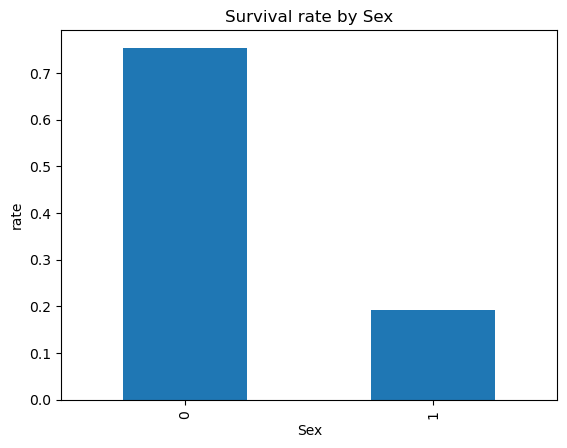

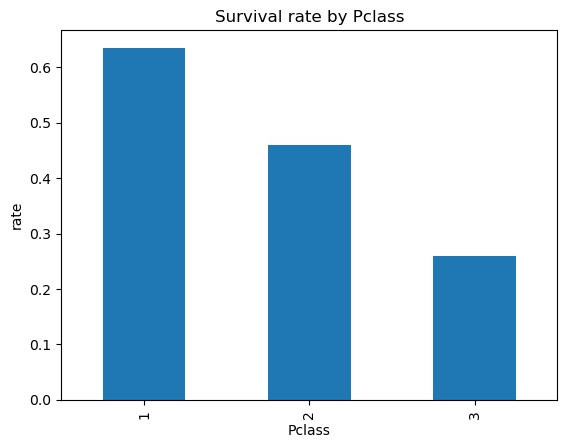

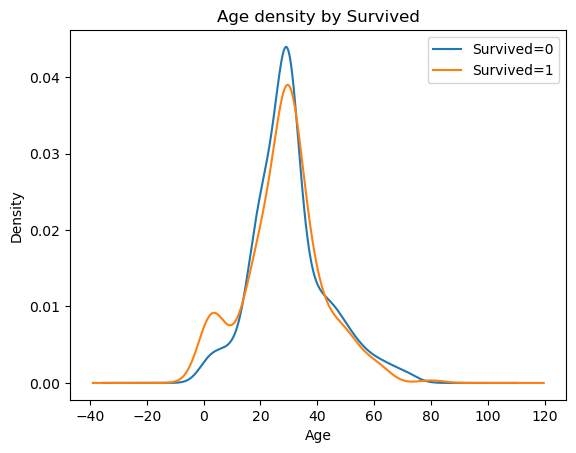

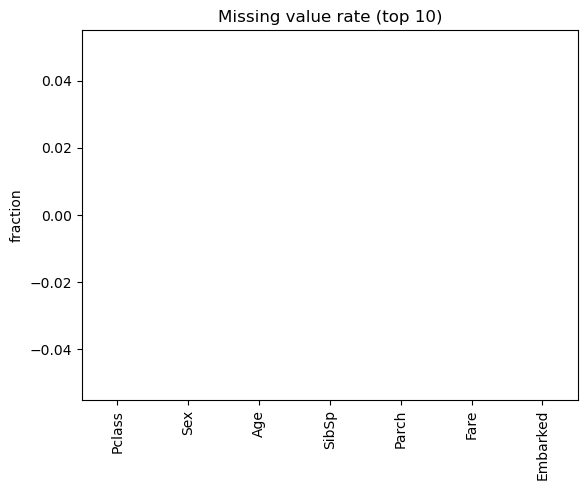

No missing values in X_train (all columns are complete).


In [4]:
# === Visual EDA ===

# 1) Survival by Sex
rates_sex = y_train.groupby(X_train["Sex"]).mean()
rates_sex.plot(kind="bar")
plt.title("Survival rate by Sex"); plt.ylabel("rate"); plt.xlabel("Sex"); plt.show()

# 2) Survival by Pclass
rates_pclass = y_train.groupby(X_train["Pclass"]).mean()
rates_pclass.plot(kind="bar")
plt.title("Survival rate by Pclass"); plt.ylabel("rate"); plt.xlabel("Pclass"); plt.show()

# 3) Age density by outcome
plt.figure()
for lab in sorted(y_train.unique()):
    s = X_train.loc[y_train==lab, "Age"].dropna()
    if len(s)>0: s.plot(kind="kde", label=f"Survived={lab}")
plt.title("Age density by Survived"); plt.xlabel("Age"); plt.legend(); plt.show()

# 4) Missing values (top 10)
na = X_train.isna().mean().sort_values(ascending=False).head(10)
na.plot(kind="bar"); plt.title("Missing value rate (top 10)"); plt.ylabel("fraction"); plt.show()
# Missing values summary (safe)
na = X_train.isna().mean().sort_values(ascending=False)

if (na == 0).all():
    print("No missing values in X_train (all columns are complete).")
else:
    na[na > 0].plot(kind="bar")
    plt.title("Missing value rate (top)")
    plt.ylabel("fraction")
    plt.show()


## Part 3 - Experiments
You could add as many code cells as needed

 Add simple features (Title, FamilySize, IsAlone, CabinDeck). Compare a few preprocessing options and models. Use 5‑fold CV with F1 to pick the best.

### Experiments: FE × Models × Hyper‑params with 5‑fold CV
**Feature Engineering:** Apply a `FunctionTransformer` that adds `Title`, `FamilySize`, `IsAlone`, `CabinDeck`, then drop high‑cardinality text.

**FE Variants:** basic / standardize / minmax / variance‑threshold.

**Models & Params:** LogisticRegression, DecisionTree, RandomForest, SVC — each with a small grid (≥2 hyper‑params).

**Validation:** **GridSearchCV** over the Cartesian product (FE × model × params) with **KFold(n_splits=5)** and **scoring='f1'**.

**Output:** A table of mean CV F1 per permutation and the selected **best** configuration.

DTypes:
 int64      5
float64    2
Name: count, dtype: int64

Missing values (train):
 Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


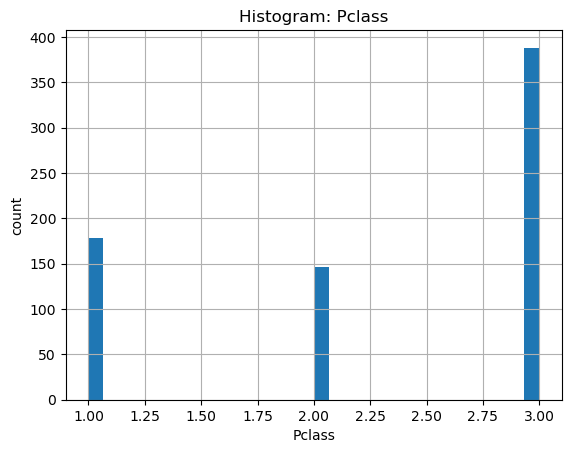

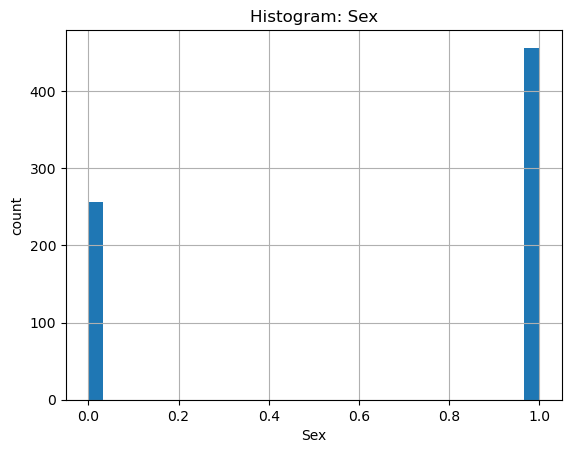

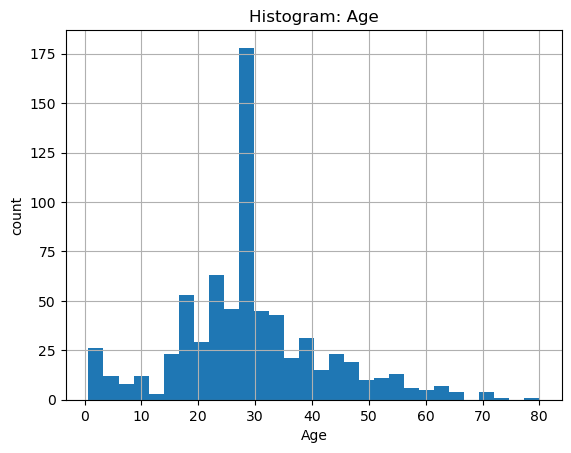

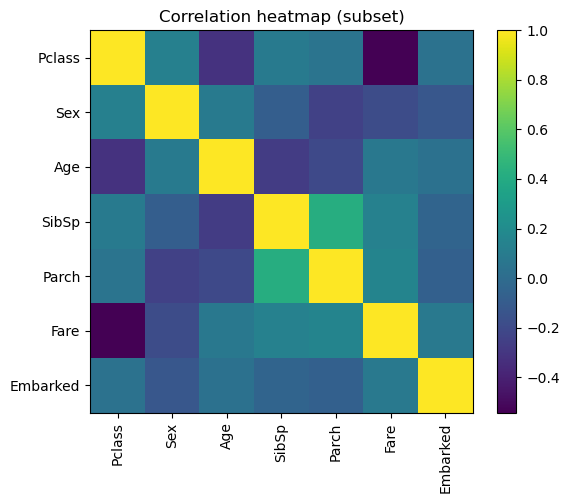

In [5]:
# === EDA (General) ===
print("DTypes:\n", X_train.dtypes.value_counts())
print("\nMissing values (train):\n", X_train.isna().sum().sort_values(ascending=False).head(20))

# Histograms for a few numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols[:3]:
    plt.figure()
    X_train[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("count"); plt.show()

# Correlation heatmap (subset)
subset = numeric_cols[:10]
if len(subset) >= 2:
    corr = X_train[subset].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation heatmap (subset)")
    plt.xticks(range(len(subset)), subset, rotation=90)
    plt.yticks(range(len(subset)), subset)
    plt.colorbar(); plt.tight_layout(); plt.show()


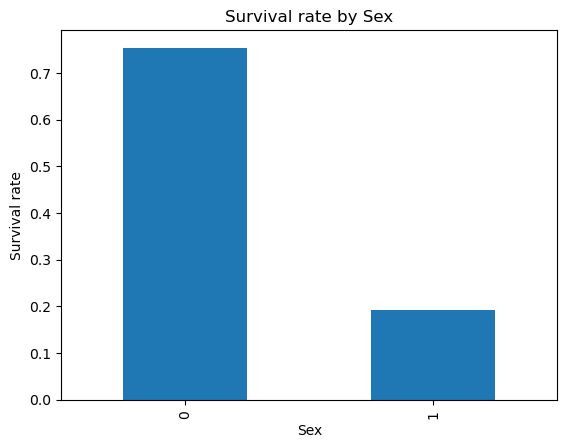

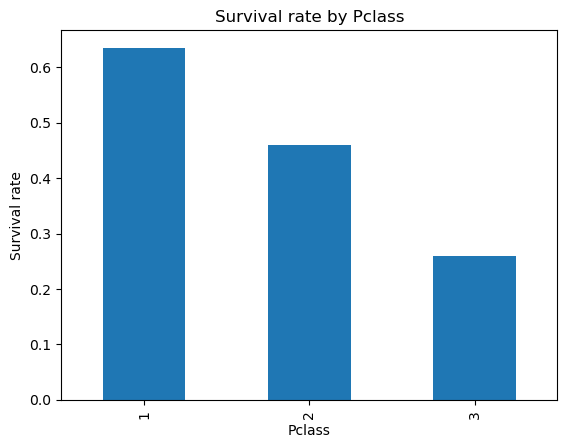

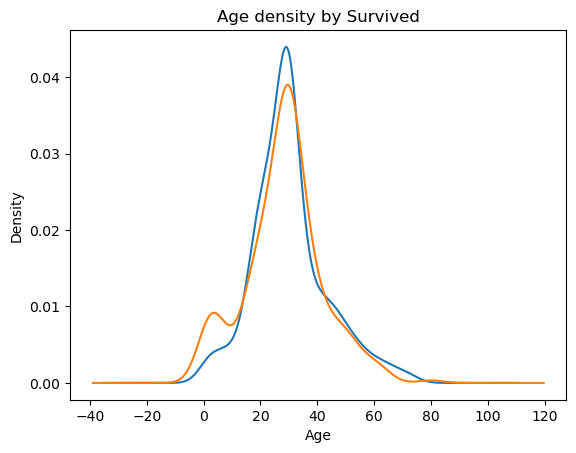

In [6]:
# === Titanic-specific EDA ===
# Survival rate by Sex
if "Sex" in X_train.columns:
    rates = y_train.groupby(X_train["Sex"]).mean()
    plt.figure(); rates.plot(kind="bar"); plt.title("Survival rate by Sex")
    plt.ylabel("Survival rate"); plt.xlabel("Sex"); plt.show()

# Survival rate by Pclass
if "Pclass" in X_train.columns:
    rates = y_train.groupby(X_train["Pclass"]).mean()
    plt.figure(); rates.plot(kind="bar"); plt.title("Survival rate by Pclass")
    plt.ylabel("Survival rate"); plt.xlabel("Pclass"); plt.show()

# Age KDE by Survived
if "Age" in X_train.columns:
    plt.figure()
    for lab in sorted(y_train.unique()):
        X_train.loc[y_train==lab, "Age"].plot(kind="kde")
    plt.title("Age density by Survived"); plt.xlabel("Age"); plt.show()


In [7]:
# === Experiments ===
feature_maker = FunctionTransformer(make_titanic_features, validate=False)

# Identify column types AFTER feature-making
X_aug = feature_maker.transform(X_train)
num_cols = X_aug.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_aug.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_basic = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])
categorical_basic = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                                    ("oh", OneHotEncoder(handle_unknown="ignore"))])

pre_basic = ColumnTransformer([("num", numeric_basic, num_cols),
                               ("cat", categorical_basic, cat_cols)])

fe_variants = {
    "basic": pre_basic,
    "standardize": ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols),
        ("cat", categorical_basic, cat_cols)
    ]),
    "minmax": ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("scaler", MinMaxScaler())]), num_cols),
        ("cat", categorical_basic, cat_cols)
    ]),
    "basic_varthresh": ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                          ("vt", VarianceThreshold(threshold=0.0))]), num_cols),
        ("cat", categorical_basic, cat_cols)
    ])
}

problem_metric = "f1"  # binary F1 as required

models_and_grids = {
    "LogisticRegression": (LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
                           {"model__C": [0.1, 1.0, 10.0]}),
    "DecisionTreeClassifier": (DecisionTreeClassifier(random_state=RANDOM_STATE),
                               {"model__max_depth": [None, 5, 10],
                                "model__min_samples_split": [2, 5]}),
    "RandomForestClassifier": (RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
                               {"model__n_estimators": [200, 400],
                                "model__max_depth": [None, 10]}),
    "SVC": (SVC(random_state=RANDOM_STATE),
            {"model__C": [0.5, 1.0], "model__kernel": ["rbf", "linear"]}),
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results_rows = []
for fe_name, pre in fe_variants.items():
    for model_name, (model_obj, grid_params) in models_and_grids.items():
        pipe = Pipeline([("feat", feature_maker), ("pre", pre), ("model", model_obj)])
        grid = GridSearchCV(pipe, param_grid=grid_params, cv=cv,
                            scoring=problem_metric, n_jobs=-1, return_train_score=False)
        grid.fit(X_train, y_train)
        # Collect CV results
        for i, mean in enumerate(grid.cv_results_["mean_test_score"]):
            params = grid.cv_results_["params"][i].copy()
            results_rows.append({
                "fe": fe_name,
                "model": model_name,
                "params": params,
                "cv_score": mean
            })

results_df = pd.DataFrame(results_rows).sort_values("cv_score", ascending=False).reset_index(drop=True)
print("Top CV results:")
display(results_df.head(20))

best_row = results_df.iloc[0]
print("\nBest configuration from CV-")
display(best_row)


Top CV results:


,fe,model,params,cv_score
0,standardize,SVC,"{'model__C': 1.0, 'model__kernel': 'rbf'}",0.765428
1,standardize,SVC,"{'model__C': 0.5, 'model__kernel': 'rbf'}",0.761160
2,standardize,DecisionTreeClassifier,"{'model__max_depth': 5, 'model__min_samples_sp...",0.750393
3,basic,DecisionTreeClassifier,"{'model__max_depth': 5, 'model__min_samples_sp...",0.750393
4,basic_varthresh,DecisionTreeClassifier,"{'model__max_depth': 5, 'model__min_samples_sp...",0.750393
5,minmax,DecisionTreeClassifier,"{'model__max_depth': 5, 'model__min_samples_sp...",0.750393
6,standardize,RandomForestClassifier,"{'model__max_depth': None, 'model__n_estimator...",0.748001
7,standardize,RandomForestClassifier,"{'model__max_depth': 10, 'model__n_estimators'...",0.744557
8,minmax,DecisionTreeClassifier,"{'model__max_depth': 5, 'model__min_samples_sp...",0.743775
9,basic_varthresh,DecisionTreeClassifier,"{'model__max_depth': 5, 'model__min_samples_sp...",0.743775



Best configuration from CV-


fe                                        standardize
model                                             SVC
params      {'model__C': 1.0, 'model__kernel': 'rbf'}
cv_score                                     0.765428
Name: 0, dtype: object

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

Refit the winning pipeline on the full training set (same preprocessing + tuned params) before testing.

### Training the best configuration
**Why:** After model selection, retrain the **winning pipeline** (chosen FE + model + best hyper‑params) on the **entire training set** to maximize learned signal.

**What we fit:** The exact pipeline printed as ‘best’ in Part 3 (same preprocessing + estimator), refit on all training data.

In [8]:
# === Retrain best on full train ===
best_fe = fe_variants[best_row["fe"]]
best_model_name = best_row["model"]
best_params = best_row["params"]

model_obj, _ = models_and_grids[best_model_name]
best_pipe = Pipeline([("feat", FunctionTransformer(make_titanic_features, validate=False)), ("pre", best_fe), ("model", model_obj)])
for k, v in best_params.items():
    best_pipe.set_params(**{k: v})
best_pipe.fit(X_train, y_train)
print("Best pipeline trained on full train set.")


Best pipeline trained on full train set.


## Part 5 - Apply on test and show model performance estimation

Evaluate on the test set — F1, classification report, confusion matrix. Add one sentence on the main error pattern.

### Test evaluation & interpretation
**Predict:** Use the trained best pipeline to predict on the **test set**.

**Report:** **F1 (binary)**, the **classification report**, and a **confusion matrix**.

**Interpret (1–2 lines):** Mention any precision/recall imbalance, where errors concentrate (e.g., false negatives),
and show a tiny preview of predictions vs. ground truth if desired (first 5 rows).

Test F1 (binary): 0.7521

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       118
           1       0.79      0.72      0.75        61

    accuracy                           0.84       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.84      0.84      0.84       179



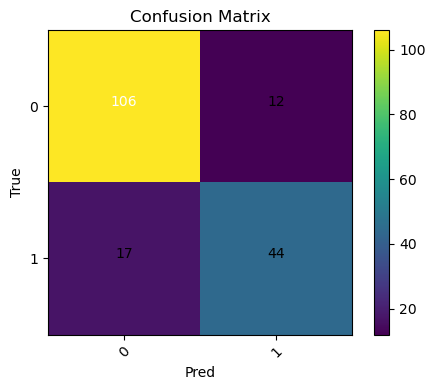

In [9]:
# === Evaluate on test set ===
y_pred = best_pipe.predict(X_test)

test_f1 = f1_score(y_test, y_pred, average="binary")
print(f"Test F1 (binary): {test_f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

labels = np.unique(np.concatenate([y_train.unique(), y_test.unique()]))
cm = confusion_matrix(y_test, y_pred, labels=labels)
show_confusion_matrix(cm, class_names=labels)


In [ ]:
# === Save predictions ===
from pathlib import Path
out = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})
out_path = Path("predictions_test.csv")
out.to_csv(out_path, index=False)
print("Saved:", out_path.resolve())
